In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [2]:
### Dask client
client = Client(n_workers=8)
display(client)

### Generate new session
db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42793/status,
Dashboard: /proxy/42793/status,Workers: 8
Total threads: 8,Total memory: 80.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46757,Workers: 8
Dashboard: /proxy/42793/status,Total threads: 8
Started: Just now,Total memory: 80.00 GiB
Comm: tcp://127.0.0.1:41807,Total threads: 1
Dashboard: /proxy/44049/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:45099,


### ACCESS-OM2

In [3]:
yr_beg = '2400-02-01'
yr_end = '2499-12-31'
expt = '1deg_jra55_ryf_cont'
var = 'temp_global_ave'
frequency = '1 daily'

access_gat_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').load()[:,0]

access_gat_sinusoids = []

access_periods = [2, 5, 7, 10, 12, 16, 20]

for i in range(len(access_periods)):
    expt = f'1deg_jra55_ryf_sinusoid_x1_period{access_periods[i]}'
    gat = cc.querying.getvar(expt, var, session, start_time = yr_beg, end_time = yr_end)[:-1].chunk(chunks='auto').load()[:,0]
    
    access_gat_sinusoids.append(gat)

### 1D model

In [4]:
# Constants, data, parameters

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho*c*z_m)
kappa = 5e-6
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 2.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz / 2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (i.e., need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top / bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking for simplicity 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top / bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e., evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e., evaluated at the top / bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T


### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        ACCESS_ave_depth = 3642
        
        OHC[i] = z_b / ACCESS_ave_depth * np.mean(T[:, i]) # This is for average temperature
        
    return OHC

def sin(amp, period):
    period_day = period * 360
    return amp * np.sin((2 * np.pi / period_day) * t)

def rolling_mean(array, period):
    window_size = int(period * 360 / (dt / 86400))
                      
    i = 0
    moving_averages = []
    while i < len(array) - window_size + 1:
        this_window = array[i : i + window_size]

        window_average = np.mean(this_window)
        moving_averages.append(window_average)
        i += 1
                      
    return np.array(moving_averages)

def final_temp_distribution(periodic_temps, temp_cont):
    return np.array([rolling_mean(OHC(periodic_temps[:,:,i] - temp_cont), onedim_periods[i])[-1] for i in range(len(onedim_periods))])

In [5]:
### Run experiment

years = 100
days = dt / 86400
M = int(z_b / dz)
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q_cont = np.zeros(int(years * 360 / days) + 1)
T0_cont = np.zeros(int(years * 360 / days) + 1)
onedim_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)

# Variable forcing

#periods = np.array([2, 5, 10, 20])
onedim_periods = np.concatenate((np.arange(0.5, 1.01, 0.1), np.array([1.5]), np.linspace(2,20,19))) #np.concatenate((np.arange(0.5, 1, 0.1), np.linspace(1,20,20)))
Q = 8
T0 = 1.0

onedim_sinusoids = np.zeros(shape = (M, N+1, onedim_periods.shape[0]))

for p in range(len(onedim_periods)):
    onedim_sinusoids[:, :, p] = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, sin(Q, onedim_periods[p]), sin(T0, onedim_periods[p]), years)
    
onedim_final_distribution = final_temp_distribution(onedim_sinusoids, onedim_cont)

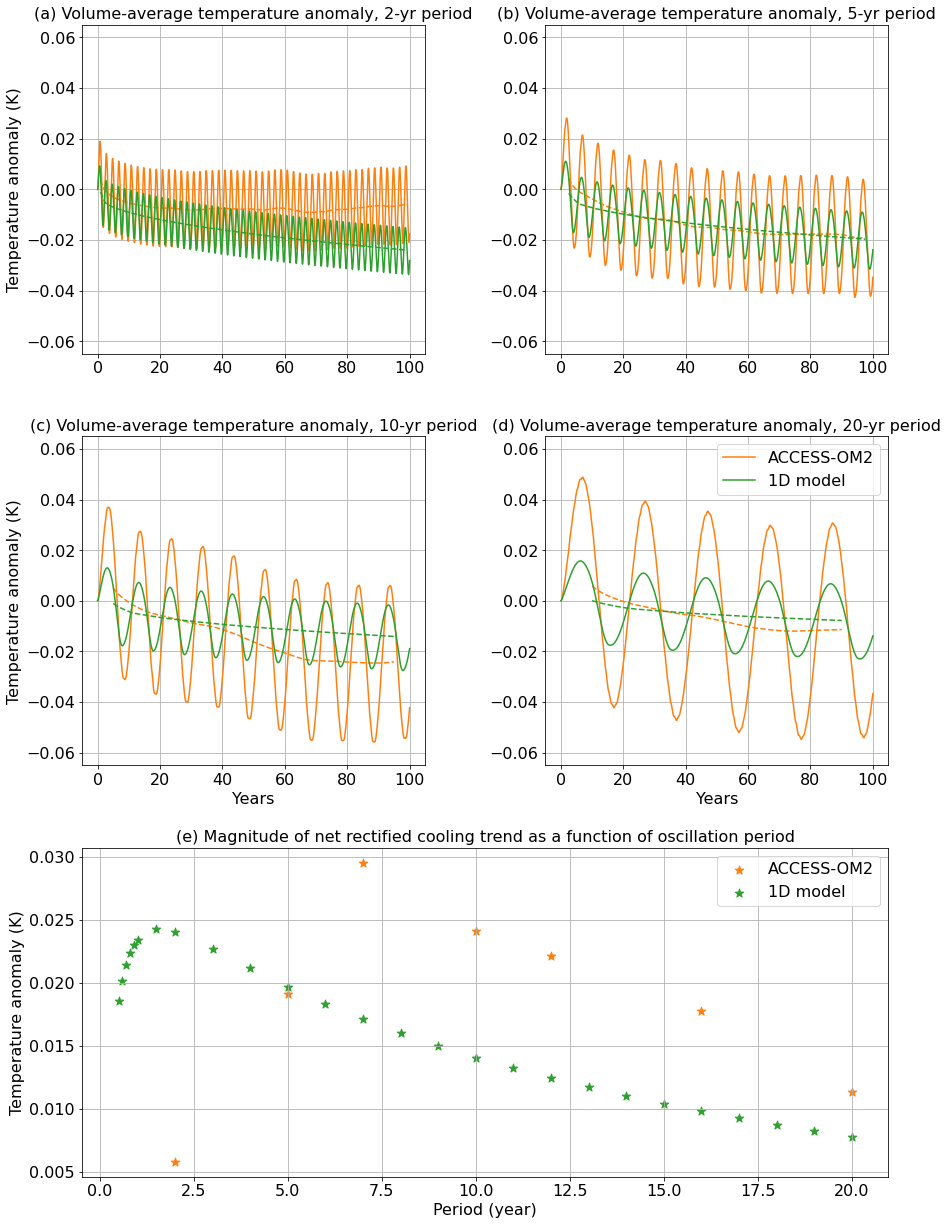

In [6]:
### Plot both ACCESS and 1D model volume-average temperatures

### Time axis for 1D model
timesteps = onedim_cont.shape[1]
length = (timesteps - 1) * days / 360
time_years = np.linspace(0,length,timesteps)
###

fig = plt.figure(figsize=(14,20))
ymax = 0.065
ymin = -0.065

### First 4 panels, show volume-average temperature in four sinusoidal runs in both ACCESS and 1D model

for i in range(4):
    periods_plot = [2., 5., 10., 20.]
    onddim_index = np.where(np.in1d(onedim_periods, periods_plot))[0]
    access_index = np.where(np.in1d(access_periods, periods_plot))[0]
    access_period = access_periods[access_index[i]]
    
    title_index = ['a','b','c','d']
    
    ax = fig.add_subplot(3, 2, i+1)
    
    access_average_temp = access_gat_sinusoids[access_index[i]] - access_gat_cont
    access_average_temp_rolling_mean = access_average_temp.rolling(time = 365 * access_period, center=True).mean().dropna('time')
    ax.plot(np.linspace(0,100,access_average_temp.shape[0]), access_average_temp, color='C1', label='ACCESS-OM2')
    ax.plot(np.linspace(0+access_period/2,100-access_period/2,access_average_temp_rolling_mean.shape[0]), access_average_temp_rolling_mean, color='C1', linestyle='--')
    
    onedim_average_temp = xr.DataArray(data = OHC(onedim_sinusoids[:,:,onddim_index[i]] - onedim_cont), coords=dict(time=time_years))
    onedim_average_temp_rolling_mean = ((onedim_average_temp).rolling(time = int(onedim_periods[onddim_index[i]] * 360 / (dt / 86400)), center=True).mean().dropna('time')).plot(ax = ax, color='C2', linestyle='--')
    onedim_average_temp.plot(ax = ax, color='C2', label='1D model')
    
    ax.set_title(f'({title_index[i]}) Volume-average temperature anomaly, {int(periods_plot[i])}-yr period', fontsize=16)
    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.grid()
    ax.set_ylim(ymin, ymax)
    
    if i == 0:
        ax.set_ylabel('Temperature anomaly (K)', fontsize=16)
    if i == 2:
        ax.set_ylabel('Temperature anomaly (K)', fontsize=16)
        ax.set_xlabel('Years', fontsize=16)
    if i == 3:
        ax.set_xlabel('Years', fontsize=16)
        
ax.legend(fontsize=16)

    
### Bottom panel, show final volume-average temperature trend distributions

ax = fig.add_subplot(3, 2, (5, 6))
ax.scatter(access_periods, [(-1*((access_gat_sinusoids[i] - access_gat_cont).rolling(time = 365 * access_periods[i], center=True).mean().dropna("time")).values[-1]) for i in range(len(access_periods))], s=80, marker='*', color='C1', label='ACCESS-OM2')
ax.scatter(onedim_periods, -1*onedim_final_distribution, s=80, marker='*', color='C2', label='1D model')
ax.grid()
ax.legend(fontsize=16)
ax.set_title('(e) Magnitude of net rectified cooling trend as a function of oscillation period', fontsize=16)
ax.set_ylabel('Temperature anomaly (K)', fontsize=16)
ax.set_xlabel('Period (year)', fontsize=16)
ax.tick_params(labelsize=16)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.35, 
                    hspace=0.25)

plt.savefig('Fig9.pdf', bbox_inches='tight', dpi=300)

In [6]:
0.029*1.3e18*4000*1035
### See Taimoor's ToE plots, in particular the ACCESS-CM2 drift between hist-nat and piControl

1.56078e+23